In [87]:
import scipy as sp
import scipy.linalg as spla
import scipy.optimize as spopt
import scipy.stats as spst

import numpy as np
import numpy.linalg as npla

import statsmodels as sm
import statsmodels.api as sma
smfOLS = sma.regression.linear_model.OLS.from_formula
smfLGT = sm.discrete.discrete_model.Logit.from_formula
from statsmodels.graphics.mosaicplot import mosaic

import seaborn as sns
sns.set(style='darkgrid')
import pandas as pd

import matplotlib.pyplot as plt

from inspect import signature as sig
import pandas as pd

#model = smfLGT("threat_level ~ age + gender + race + signs_of_mental_illness + flee + body_camera", data=df)
#model.fit().summary()

# Descriptive analysis of the data

In [38]:
df = pd.read_csv('C:/Users/Senatorous/Desktop/shootings.csv', sep=',')
df['threat_level'].replace('attack', 1 , inplace=True)
df['threat_level'].replace('undetermined', 0, inplace=True)
df['threat_level'].replace('other', 0, inplace=True)
df['age'] = df['age'].round(0).astype(int)

### Let's firstly overview the dataset

In [39]:
df.head(5)

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,arms_category
0,3,Tim Elliot,2015-01-02,shot,gun,53,M,Asian,Shelton,WA,True,1,Not fleeing,False,Guns
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47,M,White,Aloha,OR,False,1,Not fleeing,False,Guns
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23,M,Hispanic,Wichita,KS,False,0,Not fleeing,False,Unarmed
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32,M,White,San Francisco,CA,True,1,Not fleeing,False,Other unusual objects
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39,M,Hispanic,Evans,CO,False,1,Not fleeing,False,Piercing objects


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4895 entries, 0 to 4894
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       4895 non-null   int64  
 1   name                     4895 non-null   object 
 2   date                     4895 non-null   object 
 3   manner_of_death          4895 non-null   object 
 4   armed                    4895 non-null   object 
 5   age                      4895 non-null   float64
 6   gender                   4895 non-null   object 
 7   race                     4895 non-null   object 
 8   city                     4895 non-null   object 
 9   state                    4895 non-null   object 
 10  signs_of_mental_illness  4895 non-null   bool   
 11  threat_level             4895 non-null   int64  
 12  flee                     4895 non-null   object 
 13  body_camera              4895 non-null   bool   
 14  arms_category           

### The dataset consists of 4896 observations. Each observation represents a suspect killed by a US police officer for the period from 2015 to 2020. 

### Most variables are categorical. This is information about the suspect (race, gender, his weapon, etc.) and general information about the incident (state, city, flee, threat level). There are also boolean variables - the presence of visible mental illness in the suspect and the presence of a chest camera in the policeman.

<AxesSubplot:ylabel='race'>

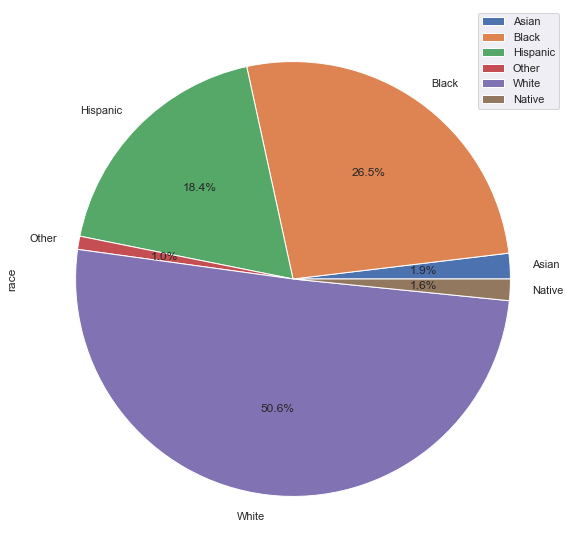

In [45]:
race_counts = df['race'].value_counts()
df_race_counts = pd.DataFrame({'race': race_counts}, 
                     index = ['Asian', 'Black', 'Hispanic', 'Other', 'White', 'Native']
                   )
df_race_counts.plot.pie(y='race', figsize=(10,10), autopct='%1.1f%%')

### As you can see, half of those killed by the police are white people. However, no conclusion can be drawn from this, because there are fewer people of color in America than the white population. There are also 26,5% of killed black suspects and 18,4% of killed hispanic people. Category other includes people of Middle East, for example.

Text(0.5, 1.0, 'Body camera')

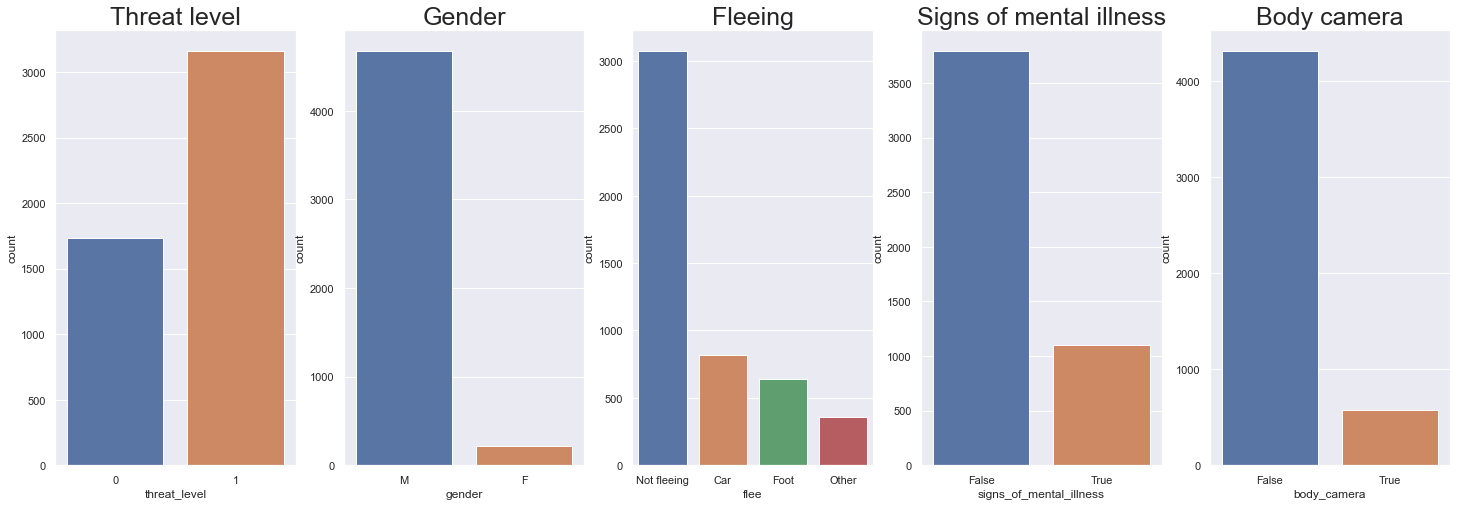

In [29]:
plt.figure(figsize=(25,8))
plt.subplot(1,5,1)
sns.countplot(x='threat_level', data=df)
plt.title('Threat level', fontsize=25)

plt.subplot(1,5,2)
sns.countplot(x='gender', data=df)
plt.title('Gender', fontsize=25)

plt.subplot(1,5,3)
sns.countplot(x='flee', data=df)
plt.title('Fleeing', fontsize=25)

plt.subplot(1,5,4)
sns.countplot(x='signs_of_mental_illness', data=df)
plt.title('Signs of mental illness', fontsize=25)

plt.subplot(1,5,5)
sns.countplot(x='body_camera', data=df)
plt.title('Body camera', fontsize=25)

#plt.figure(figsize=(20,10))
#ax = sns.countplot(x='threat_level', data=df)

### The threat level variable is of the greatest interest to us. The value 1 - implies an Attack, the officer in the investigation indicated the actions as an attack. If the value of this variable is 0, it means that the officer definitely did not evaluate the suspect's action as an attack. The suspect reached for his pocket, made a sharp movement, his hands were out of sight of the officer - all these actions are characterized as not an attack

### Other variables have a fairly obvious distribution. Most of those killed are males who wasn't fleeing. Most of the people had no visible mental disorders and at the same time only one in eight police officers had a body camera.

Text(0.5, 1.0, 'State')

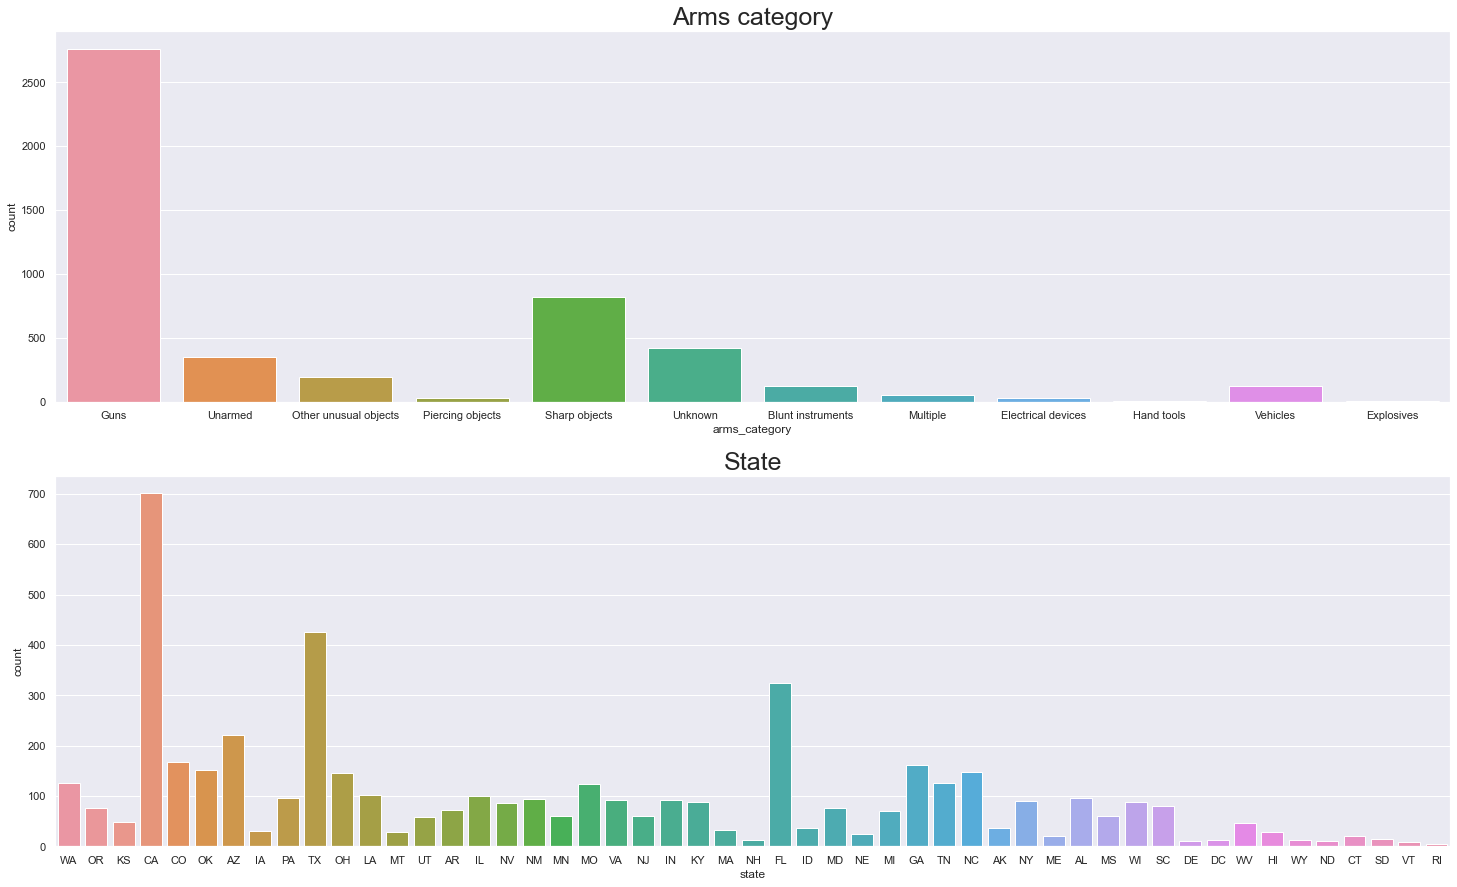

In [28]:
plt.figure(figsize=(25,15))
plt.subplot(2,1,1)
sns.countplot(x='arms_category', data=df)
plt.title('Arms category', fontsize=25)

plt.subplot(2,1,2)
sns.countplot(x='state', data=df)
plt.title('State', fontsize=25)

### Another very important detail is the weapon possessed by the killed suspects. Most of them had firearms with them. The second most popular weapon is sharp objects. At the same time, you can pay attention to the fact that 348 people were not armed at all, and 171 people were armed with toy weapons (this is included in the category of other unusual objects)

### Also where are states with the most cases of police shooting. It's California, Texas and Florida. So the reason os that that's are the most populated states.

<AxesSubplot:xlabel='age', ylabel='count'>

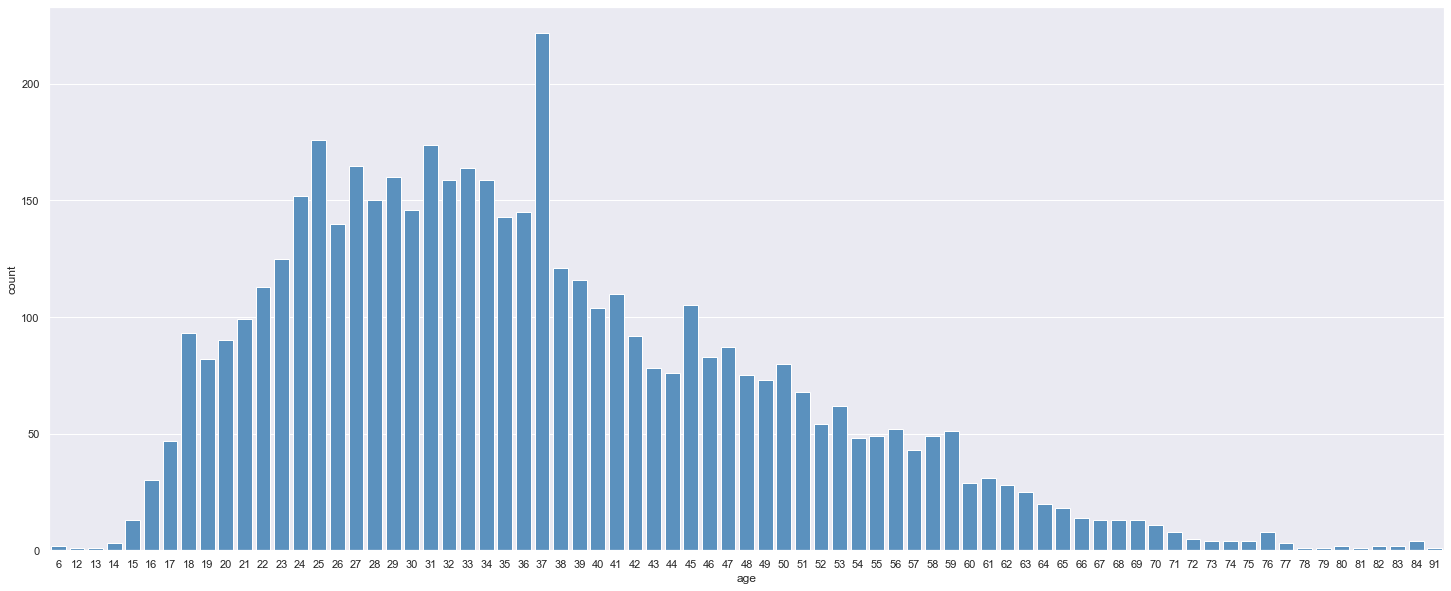

In [68]:
plt.figure(figsize=(25,10))
sns.countplot(x='age', data=df, color='#4a93cf')

#### The age distribution does not look like normal, however it should be checked by appropriate tests.

In [43]:
spst.normaltest(df['age'], axis=0, nan_policy='propagate')

NormaltestResult(statistic=346.5169363006812, pvalue=5.685953966205574e-76)

#### Test demonstrted that the distribution of age is not normal

### Is there any relation between the fact that the suspect purposefully attacks a policeman and any other signs of him? As an example, let's take a race, and see the distribution of races between the meaning of "attacks" and "does not attack"

In [69]:
race_attack = pd.crosstab(df['threat_level'], df['race'])
race_attack

race,Asian,Black,Hispanic,Native,Other,White
threat_level,,,,,,
0,42,425,381,34,17,836
1,51,873,521,44,31,1640


### The dependency, if there is one, is not obvious. We can check its presence or absence using the Chi-square test

In [80]:
chi2, p, dof, expected = spst.chi2_contingency(race_attack) 
if p<0.05: print(p, '\n', 'So we reject null hypothesis and there is which means that there is an association between threat level and race')
else: print(p, 'So we accept null hypothesis and there is which means that there is no association between threat level and race')

7.4721950552183445e-06 
 So we reject null hypothesis and there is which means that there is an association between threat level and race


### Chi-square test shows us, that there is relation between this two categorical variables. 

In [101]:
expected_df = pd.DataFrame(data=expected,
                   columns=['Asian', 'Black', 'Hispanic', 'Native', 'Other', 'White'])
chi_residuals = expected_df - race_attack

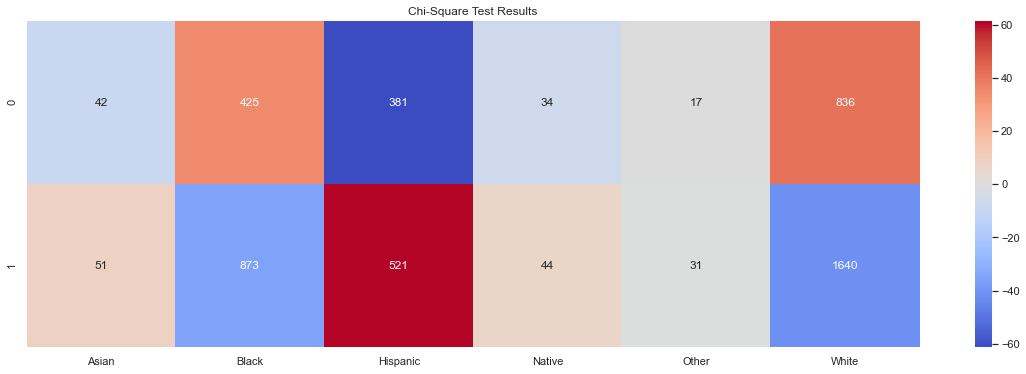

In [123]:
fig = plt.figure(figsize=(20,6))
sns.heatmap(chi_residuals, annot=race_attack, cmap='coolwarm', fmt='.4g')
plt.title('Chi-Square Test Results')
plt.show()

### This graph is a visualization of the Chi-square test. It shows great Chi-residues in the case of white, black and hispanic people. That is, their number among attackers or non-attackers differs significantly from the expected one, in which the threat level does not depend on race

### Окей, пояснение про хи квадрат. Этот тест посмотрел, есть ли разница между нашим датасетом, и "идеальным" датасетом, где для всех рас пропорции одинаковые. И вот где испанцы получились красные, а черные и белые оранжевые, значит там эта диспропорция очень ощутимая. То есть именно тот факт, что ты латинос, черный или белый сильнее влияет на то, атакуешь ты или нет